In [1]:
import argparse
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Galaxies
import torch
import wandb


%load_ext autoreload
%autoreload 2

In [ ]:
wandb.init()


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [7]:
model = Unet(
    dim = 64,
    dim_mults = (1, 1, 2, 2, 2, 4, 4, 4)
).to(device=DEVICE)

diffusion = GaussianDiffusion(
    model,
    image_size =128,
    timesteps = 1000,
    loss_type = 'l2'
).to(device=DEVICE)

In [12]:
trainer = Trainer(
    diffusion,
    folder = '/pscratch/sd/s/sihany/desiimages/',
    logdir = '/pscratch/sd/s/sihany/logs/desi_improved/',
    image_size = 128,
    train_batch_size = 16,
    train_lr = 1e-4,
    train_num_steps = 100000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    step_start_ema = 5000,
    save_every = 5000,
    sample_every = 3000,
    num_workers=16,
    # rank = [0, 1, 2]
)

In [13]:
trainer.load(300000)

In [50]:
trainer.train()

loss = 0.031105846166610718:   2%|▏         | 1560/100000 [03:16<3:26:56,  7.93it/s]  


KeyboardInterrupt: 

sampling loop time step: 100%|██████████| 1000/1000 [01:43<00:00,  9.69it/s]
/tmp/ipykernel_1032594/4102481137.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  eax.imshow(all_images[i].cpu().T/255)


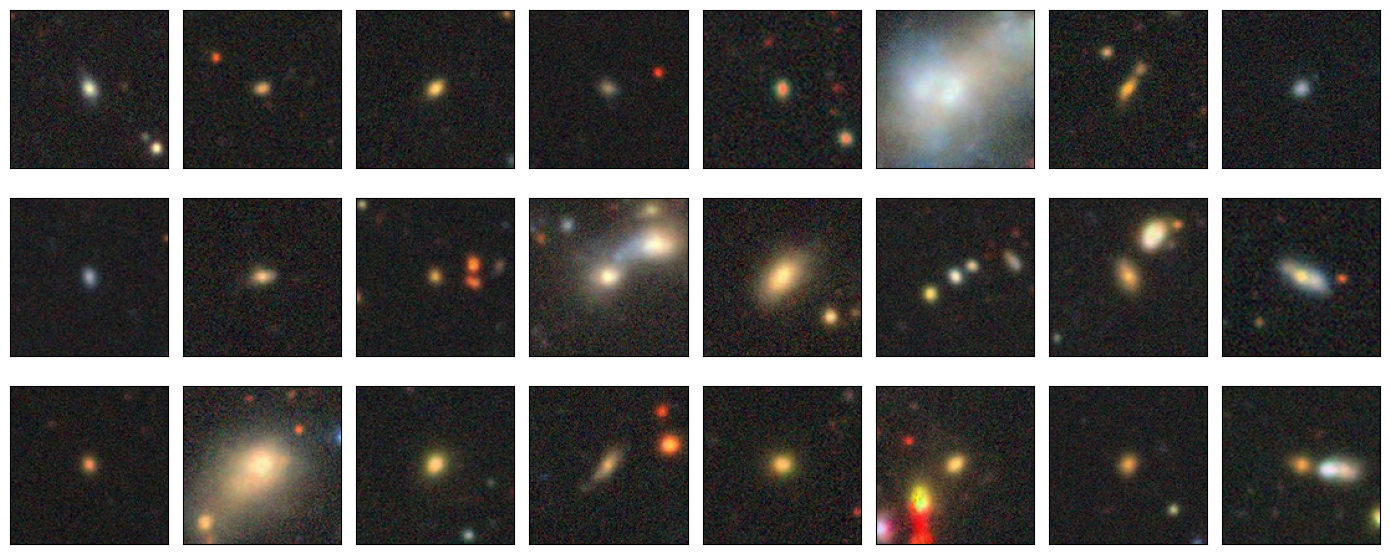

In [5]:
# sample and plot
trainer.load(50000)

all_images = trainer.ema_model.module.sample(128, batch_size = 24)
all_images = (all_images + 1)/2*255
# all_images = list(map(lambda x: (x - 0)/(255 - 0), all_images))
# all_images = torch.flip(all_images, dims=[1]) # map channels correctly for imout
all_images = all_images.round()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14, 6), ncols = 8, nrows = 3)
for i, eax in enumerate(ax.flatten()):
    eax.imshow(all_images[i].cpu().T/255)
    eax.set_xticks([])
    eax.set_yticks([])

plt.tight_layout()

# FID score

In [7]:
import numpy as np
from tqdm import tqdm
from glob import glob
import re
from os.path import basename, getsize
from matplotlib.image import imread
from PIL import Image

def check_for_corruption(ar):
    '''
    Check if the galaxies are there and then remove the image if its
    not there.
    
    If more than 1/3 of the pixels are duds we don't want that gal.
    '''
    nanned = np.any(~np.isfinite(ar))
    zeroed = np.sum(ar == 0) > (ar.size*0.3)
    return np.any((nanned, zeroed))

for fi in tqdm(sorted(glob('/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_*.jpg'))):
    if getsize(fi) < 5000:
        print(f'{fi} is empty, not dealing with that...')
        continue
    try:
        a = imread(fi)
        g = a[:,:,0]
        r = a[:,:,1]
        z = a[:,:,2]

        if any(map(check_for_corruption, (g, r, z))):
            print(f'Removing corrupted/missing pixels image: {fi}')
            continue

    except Exception as e:
        print(f'Problem with loading, skipping that one...\n{e}')
        continue

    gal = np.stack([g, r, z], axis=0)
    gal = gal[:, gal.shape[1]//2 - 64:gal.shape[1]//2 + 64, gal.shape[2]//2 - 64:gal.shape[2]//2 + 64]
    im = Image.fromarray(gal.astype(np.uint8).T)
    
    im.save(f'/pscratch/sd/s/sihany/logs/tests/{basename(fi)[11:-5]}.jpeg')

 39%|███▉      | 7884/20000 [00:50<01:17, 156.88it/s]

Removing corrupted/missing pixels image: /pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_39628069408866866.jpg


100%|██████████| 20000/20000 [02:11<00:00, 152.67it/s]


In [ ]:
# generate a synthetic set for fid and sgd scores
import numpy as np
from PIL import Image

milestone = 300000
trainer.load(milestone)
fakedir = '/pscratch/sd/s/sihany/logs/fakes/'+str(milestone)+'/'

batchsize = 400
for i in range(0, 30):
    all_images = trainer.ema_model.module.sample(128, batch_size = batchsize)
    
    all_images = (all_images + 1)/2*255
    # all_images = list(map(lambda x: (x - 0)/(255 - 0), all_images))
    # all_images = torch.flip(all_images, dims=[1]) # map channels correctly for imout
    all_images = all_images.round()
      
    for eid, im in enumerate(all_images):
        im = Image.fromarray(im.cpu().numpy().astype(np.uint8).T)
        im.save(fakedir+str(eid+i*batchsize)+".jpeg")


sampling loop time step:  39%|███▉      | 394/1000 [02:33<03:56,  2.56it/s]

In [1]:
!python -m pytorch_fid --device cuda:2 --batch-size 100 /pscratch/sd/s/sihany/logs/fakes/110000/ /pscratch/sd/s/sihany/logs/tests/

100%|█████████████████████████████████████████| 181/181 [00:09<00:00, 18.87it/s]
FID:  34.13141100539383


In [ ]:
# 50000 steps, 2000 fakes, fid = 39.35 , increasing to 3000 fakes, fid = 38.58, between two subsets of training sample, fid = 3.07
# 110000 steps, 2500 fakes, fid = 35.19, 11000 fakes, fid = 34

# how does it compare to the diffusers? diffuser fid = 90... not sure why its so bad

# fixed the channel flipping, now the fid = 4.20, with the 110000 steps model
# with the 300000 steps model, which has a reduced size of 64, fid = 8.01




# check images

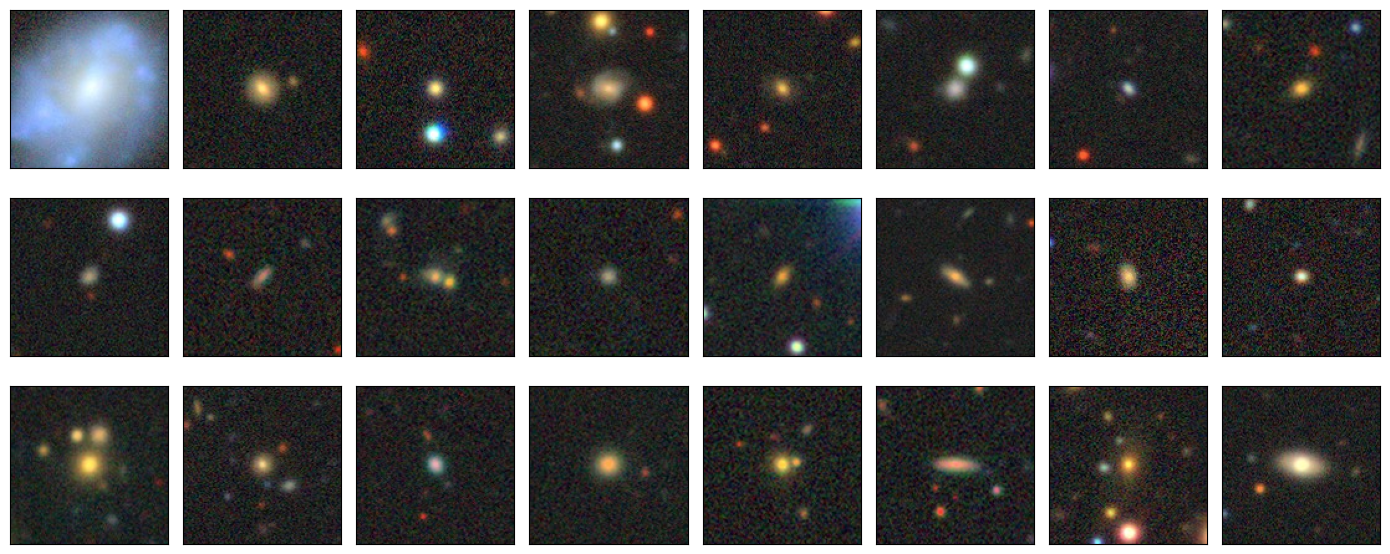

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from astropy.io import fits
from glob import glob
import random

# catalog = fits.open('/pscratch/sd/v/virajvm/sandy_imgs/jura_bgs_N_20000.fits')[1].data
# ids = catalog['TARGETID']
# maskrflux = catalog['FLUX_R'] > 0
# ids_sel = ids[maskrflux]

# fns = [f'/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_{eid}.jpg' for eid in ids_sel]

fns = glob('/pscratch/sd/s/sihany/desiimages/*.npy')

rfns = random.sample(fns, 24)

fig, ax = plt.subplots(figsize = (14, 6), ncols = 8, nrows = 3)
    
for i, eax in enumerate(ax.flatten()):
    a = np.load(rfns[i])
    eax.imshow(a.T)
    eax.set_xticks([])
    eax.set_yticks([])
    
    
plt.tight_layout()


In [72]:
a

array([[[39, 41, 36, ...,  4,  8, 21],
        [28, 37, 36, ...,  5, 17, 37],
        [ 1, 14, 31, ..., 30, 25, 33],
        ...,
        [40, 19, 39, ..., 23, 16, 23],
        [37, 44, 40, ..., 15, 12, 27],
        [47, 47, 57, ..., 32, 18, 25]],

       [[28, 29, 28, ..., 24, 20, 32],
        [27, 34, 25, ..., 25, 32, 50],
        [20, 26, 26, ..., 26, 25, 38],
        ...,
        [35,  7, 35, ..., 38, 26, 32],
        [26, 25, 31, ..., 27, 19, 35],
        [32, 29, 49, ..., 41, 23, 27]],

       [[45, 39, 25, ..., 13, 18, 26],
        [43, 41, 19, ..., 16, 27, 41],
        [24, 26, 22, ..., 27, 25, 32],
        ...,
        [39,  9, 32, ..., 15, 27, 41],
        [32, 27, 24, ..., 25, 35, 48],
        [37, 29, 38, ..., 48, 43, 42]]], dtype=uint8)